In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from prophet.plot import plot_components
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from statsmodels.graphics import tsaplots
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
from sklearn.preprocessing import MinMaxScaler

# Suppress specific statsmodels warnings about frequency
warnings.filterwarnings('ignore', 'No frequency information was provided')
warnings.filterwarnings('ignore', 'No supported index is available')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=ValueWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

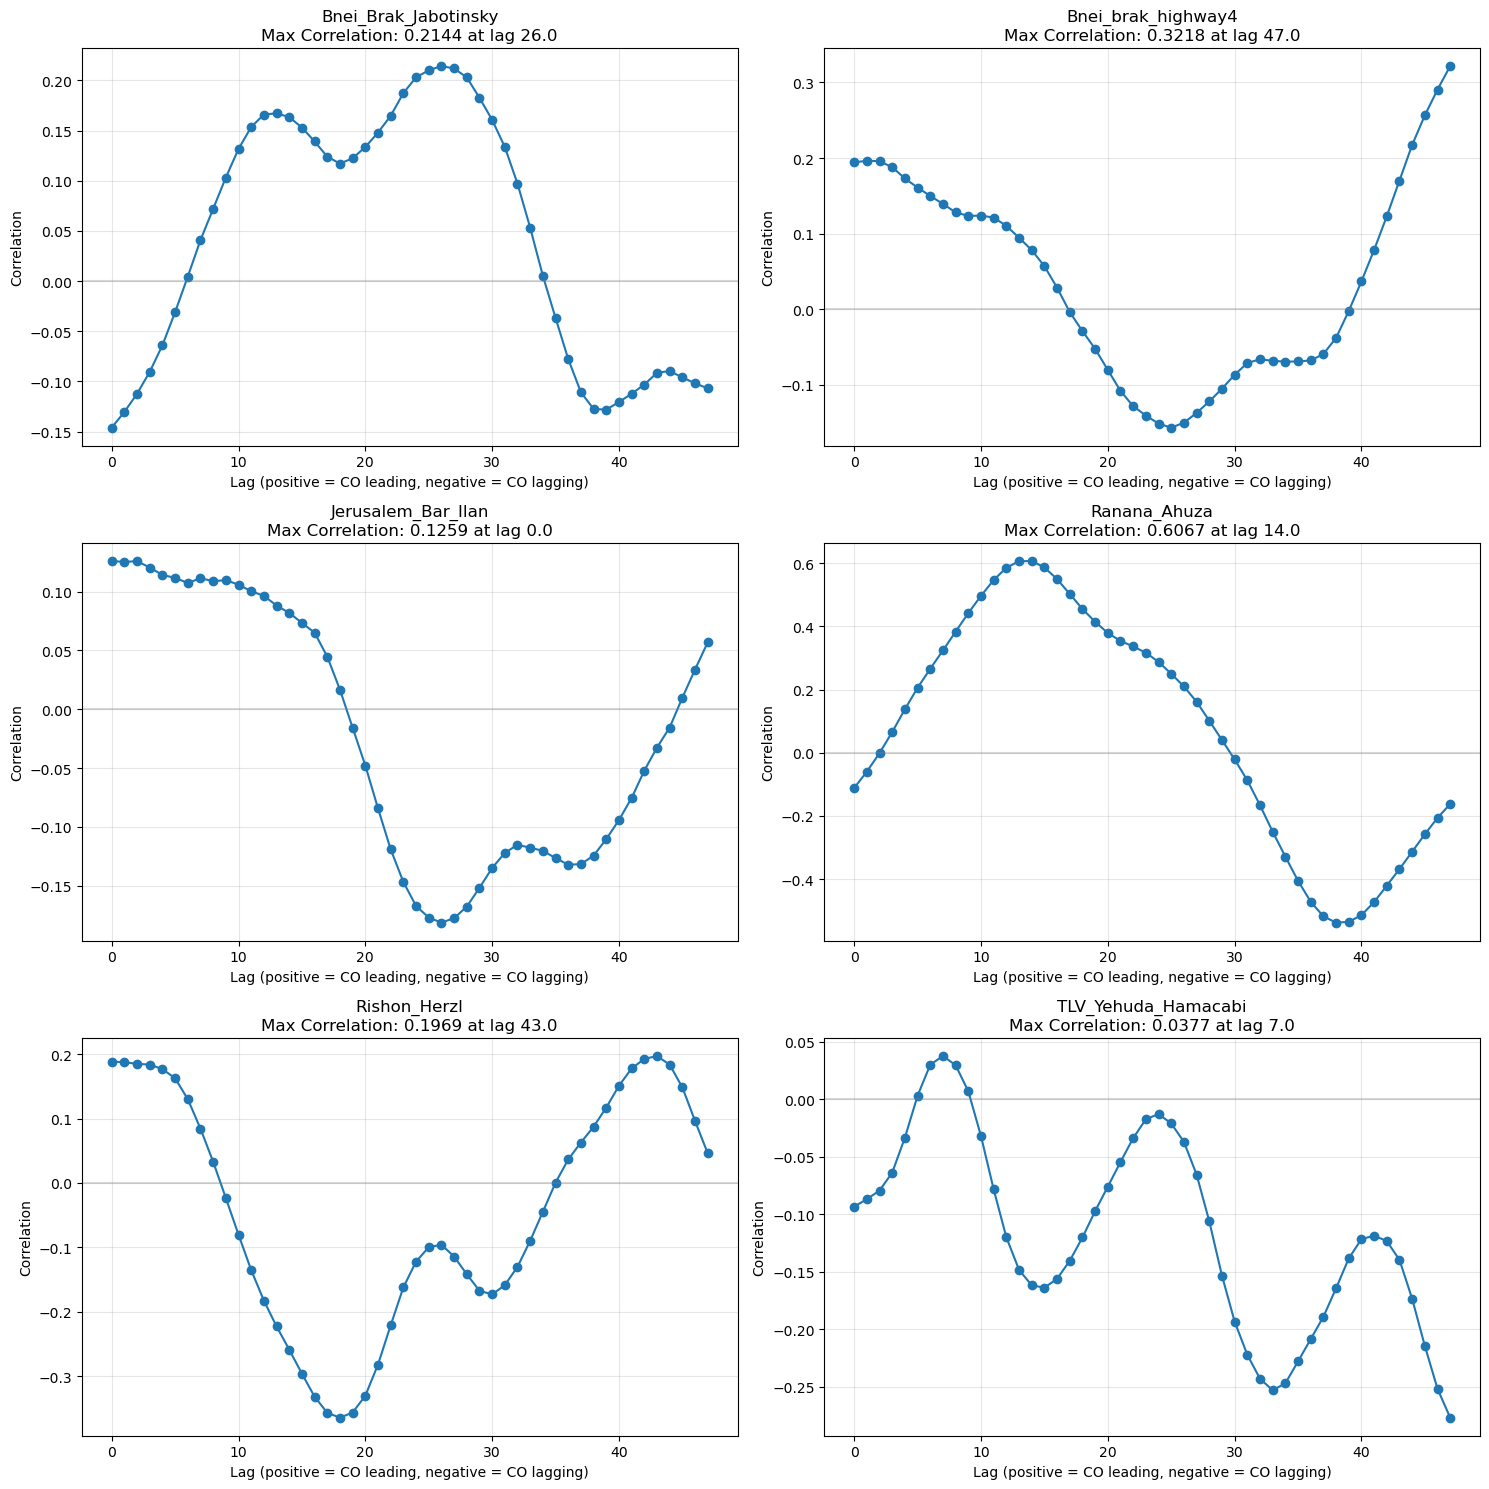

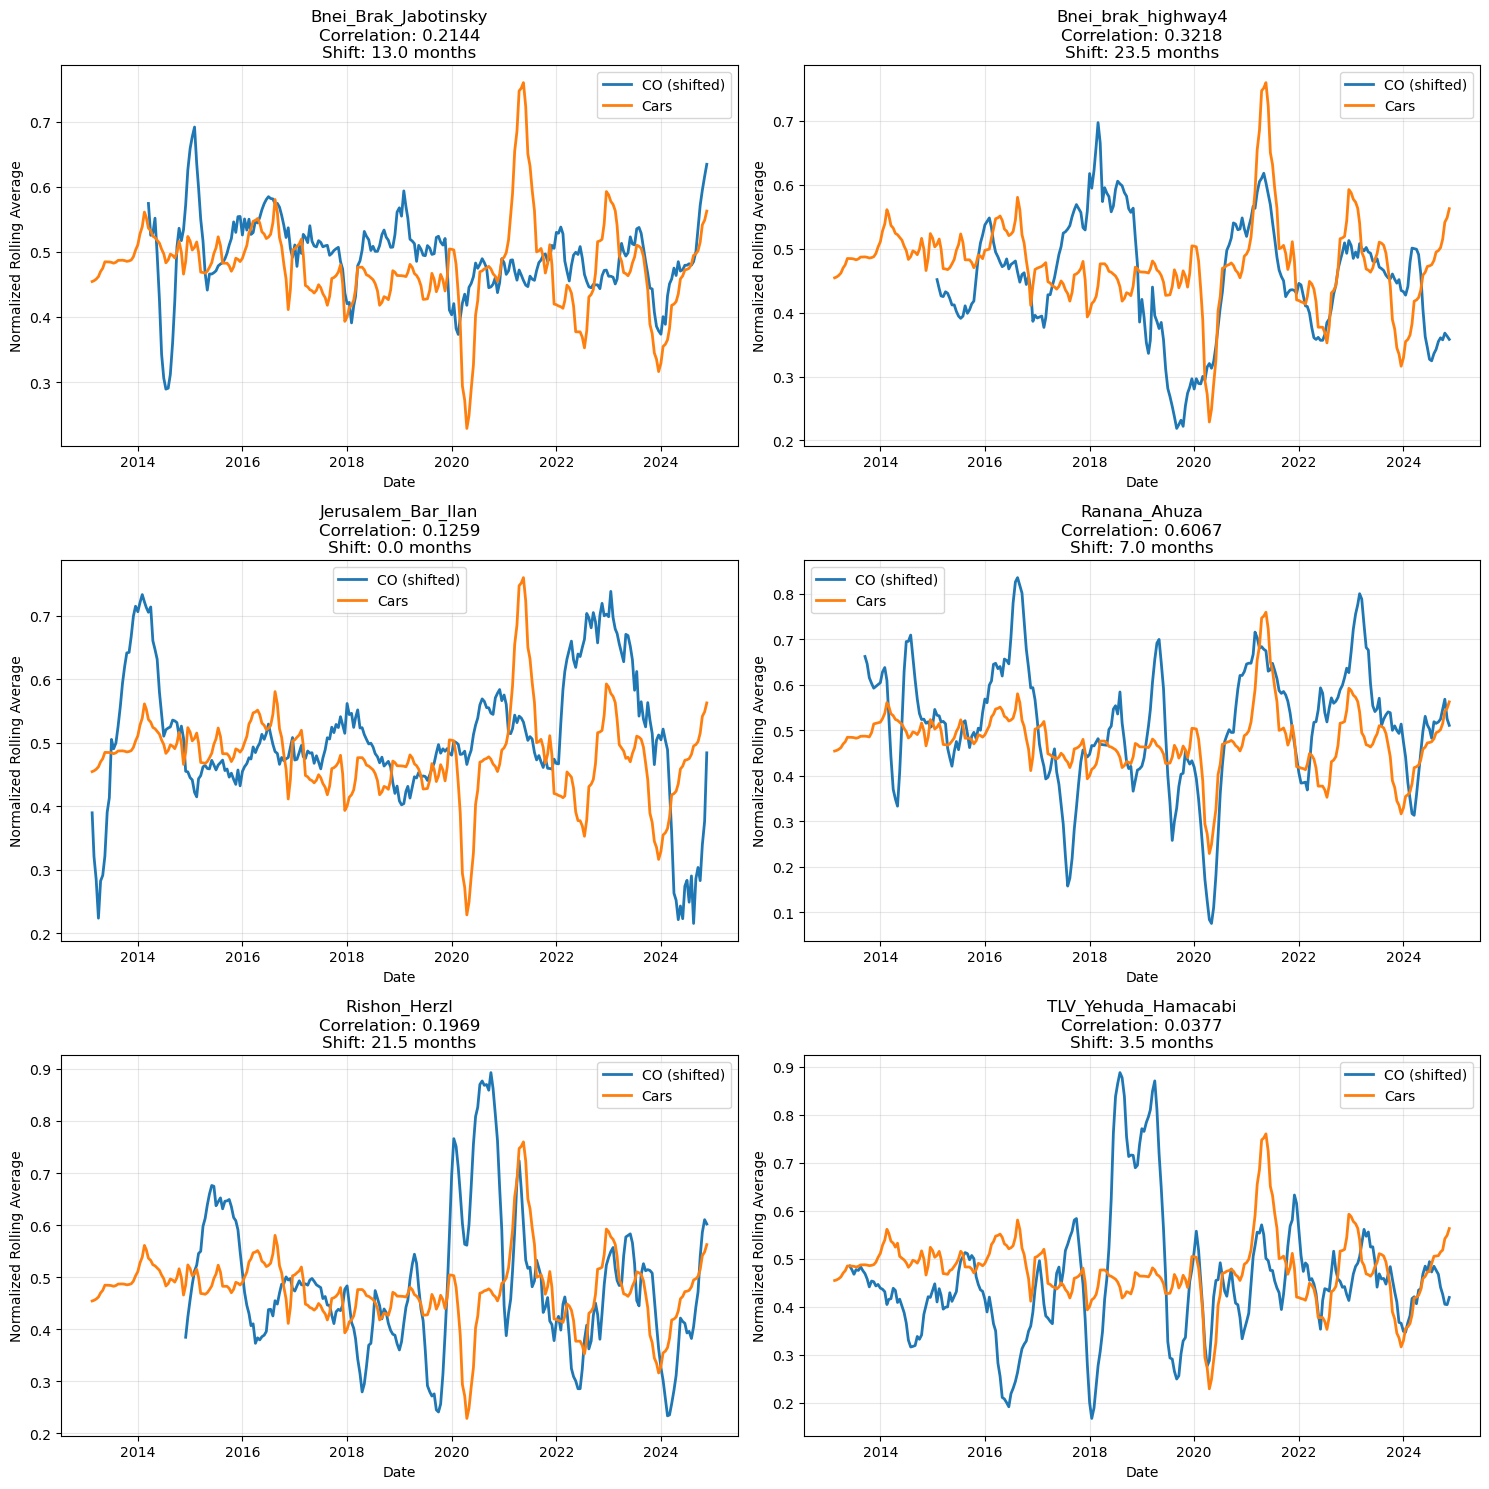


Rolling Average Analysis Summary for All Stations:
Window size: 6 periods (3 months)

Station-wise Results:
--------------------------------------------------------------------------------

Station: Bnei_Brak_Jabotinsky
Optimal lag: 26.0 periods (13.0 months)
Maximum correlation: 0.2144

Station: Bnei_brak_highway4
Optimal lag: 47.0 periods (23.5 months)
Maximum correlation: 0.3218

Station: Jerusalem_Bar_Ilan
Optimal lag: 0.0 periods (0.0 months)
Maximum correlation: 0.1259

Station: Ranana_Ahuza
Optimal lag: 14.0 periods (7.0 months)
Maximum correlation: 0.6067

Station: Rishon_Herzl
Optimal lag: 43.0 periods (21.5 months)
Maximum correlation: 0.1969

Station: TLV_Yehuda_Hamacabi
Optimal lag: 7.0 periods (3.5 months)
Maximum correlation: 0.0377


In [35]:
# Load the datasets
df_air = pd.read_csv('data/co_half_monthly.csv', parse_dates=['Date'])
df_cars = pd.read_csv('data/cars_transformed.csv', parse_dates=['Date'])

# Set the Date column as the index for cars data
df_cars.set_index('Date', inplace=True)
dfCars = df_cars[['car_num']]

# Filter data from 2012 to end of 2024
dfCars = dfCars[(dfCars.index >= '2012-01-01') & (dfCars.index <= '2024-12-31')]
yearly_integration_cars = dfCars.diff(periods=24).dropna()

def find_max_correlation(series1, series2, max_lag=48):
    """Find maximum correlation and optimal lag"""
    lag_range = range(0, max_lag)
    correlations = []
    for lag in lag_range:
        if lag == 0:
            corr = series1.corr(series2)
        else:
            corr = series1.shift(lag).corr(series2)
        correlations.append((lag, corr, abs(corr)))
    
    corr_df = pd.DataFrame(correlations, columns=['lag', 'correlation', 'abs_correlation'])
    optimal_lag = corr_df.loc[corr_df['correlation'].idxmax()]
    return optimal_lag, corr_df

def process_station_data(station_data, yearly_integration_cars):
    # Filter data from 2012 to end of 2024
    station_data = station_data[(station_data.index >= '2012-01-01') & (station_data.index <= '2024-12-31')]
    yearly_integration_co = station_data.diff(periods=24).dropna()
    
    # Ensure both series have the same index
    common_index = yearly_integration_co.index.intersection(yearly_integration_cars.index)
    yearly_integration_co = yearly_integration_co.loc[common_index]
    yearly_integration_cars = yearly_integration_cars.loc[common_index]
    
    # Normalize the data
    scaler = MinMaxScaler()
    yearly_integration_co_scaled = scaler.fit_transform(yearly_integration_co)
    yearly_integration_cars_scaled = scaler.fit_transform(yearly_integration_cars)
    
    # Create DataFrame with both series
    combined_df = pd.DataFrame({
        'co': yearly_integration_co_scaled.flatten(),
        'cars': yearly_integration_cars_scaled.flatten()
    }, index=common_index)
    
    # Apply rolling average
    window = 6  # 3 months of bi-monthly data
    roll_co = combined_df['co'].rolling(window=window, center=True).mean().dropna()
    roll_cars = combined_df['cars'].rolling(window=window, center=True).mean().dropna()
    
    return roll_co, roll_cars

# Get unique stations
stations = df_air['station'].unique()

# Create subplots in a grid
n_stations = len(stations)
n_cols = 2
n_rows = (n_stations + 1) // 2  # Round up division

# First figure: Correlation Analysis
plt.figure(figsize=(15, 5*n_rows))

for idx, station in enumerate(stations, 1):
    # Filter data for current station
    station_data = df_air[df_air['station'] == station].set_index('Date')[['CO']]
    roll_co, roll_cars = process_station_data(station_data, yearly_integration_cars)
    
    # Calculate optimal lag
    optimal_lag, corr_df = find_max_correlation(roll_co, roll_cars)
    
    # Create subplot
    plt.subplot(n_rows, n_cols, idx)
    
    # Plot correlation analysis
    plt.plot(corr_df['lag'], corr_df['correlation'], marker='o')
    plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    plt.title(f'{station}\nMax Correlation: {optimal_lag["correlation"]:.4f} at lag {optimal_lag["lag"]}')
    plt.xlabel('Lag (positive = CO leading, negative = CO lagging)')
    plt.ylabel('Correlation')
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Second figure: Time Series Comparison
plt.figure(figsize=(15, 5*n_rows))

for idx, station in enumerate(stations, 1):
    # Filter data for current station
    station_data = df_air[df_air['station'] == station].set_index('Date')[['CO']]
    roll_co, roll_cars = process_station_data(station_data, yearly_integration_cars)
    
    # Calculate optimal lag
    optimal_lag, _ = find_max_correlation(roll_co, roll_cars)
    
    # Create subplot
    plt.subplot(n_rows, n_cols, idx)
    
    # Plot time series with optimal lag
    shifted_co = roll_co.shift(int(optimal_lag['lag']))
    plt.plot(shifted_co.index, shifted_co, label='CO (shifted)', linewidth=2)
    plt.plot(roll_cars.index, roll_cars, label='Cars', linewidth=2)
    plt.title(f'{station}\nCorrelation: {optimal_lag["correlation"]:.4f}\nShift: {optimal_lag["lag"]/2:.1f} months')
    plt.xlabel('Date')
    plt.ylabel('Normalized Rolling Average')
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary for all stations
print("\nRolling Average Analysis Summary for All Stations:")
print(f"Window size: 6 periods (3 months)")
print("\nStation-wise Results:")
print("-" * 80)
for station in stations:
    station_data = df_air[df_air['station'] == station].set_index('Date')[['CO']]
    roll_co, roll_cars = process_station_data(station_data, yearly_integration_cars)
    optimal_lag, _ = find_max_correlation(roll_co, roll_cars)
    print(f"\nStation: {station}")
    print(f"Optimal lag: {optimal_lag['lag']} periods ({optimal_lag['lag']/2:.1f} months)")
    print(f"Maximum correlation: {optimal_lag['correlation']:.4f}")

We ca see the best outcome is when we shift the car data 7 months forward, this achieves ~0.6 correlation on the Ranana_Ahuza station dataset

Train shape: (253, 1)
Test shape: (45, 1)

--- Prophet without exogenous variables ---


12:35:34 - cmdstanpy - INFO - Chain [1] start processing
12:35:34 - cmdstanpy - INFO - Chain [1] done processing


Prophet without exogenous variables - MSE: 0.0202, RMSE: 0.1420, MAE: 0.1222

--- Prophet with exogenous variables (cars) ---


12:35:35 - cmdstanpy - INFO - Chain [1] start processing
12:35:35 - cmdstanpy - INFO - Chain [1] done processing


Prophet with exogenous variables - MSE: 0.0184, RMSE: 0.1356, MAE: 0.1164

--- Performance Comparison ---
Performance improvement with exogenous variables: 8.81%
Average confidence interval width - Without exog: 0.4448, With exog: 0.4385
Confidence interval width reduction: 1.42%


,Prophet without Cars,Prophet with Cars,Improvement (%)
Metric,,,
MSE,0.0202,0.0184,8.81%
RMSE,0.1420,0.1356,4.51%
MAE,0.1222,0.1164,4.71%
CI Width,0.4448,0.4385,1.42%
Training Size,253,253,-
Test Size,45,45,-


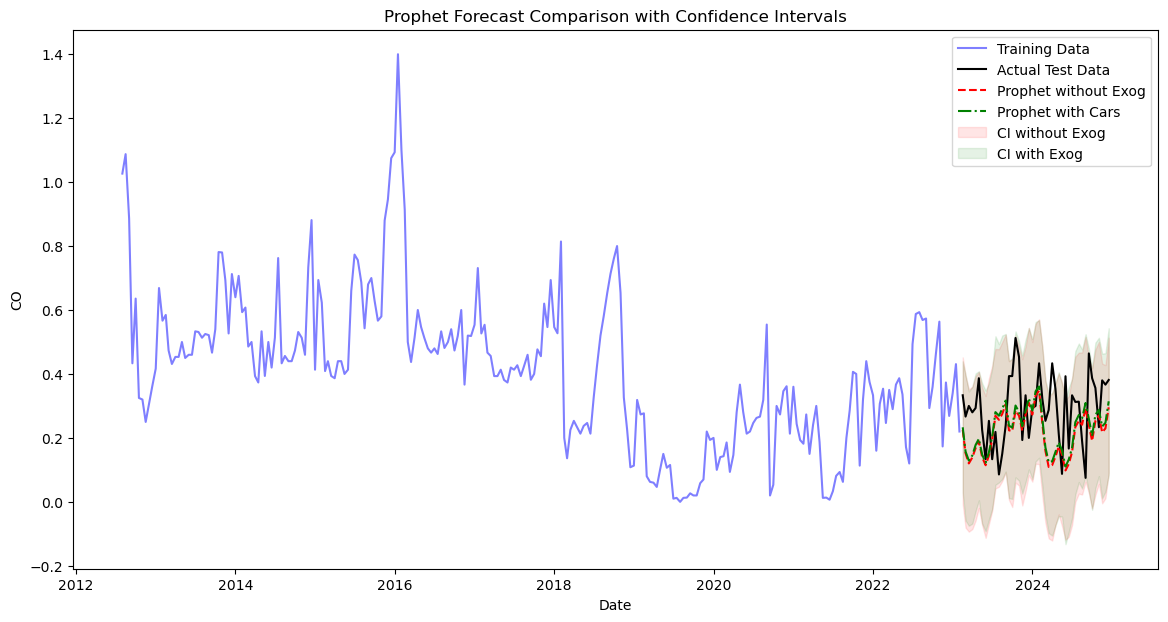

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

In [36]:

# ---------------------
# 1. Load Data and Filter
# ---------------------
# Load the datasets
df_air = pd.read_csv('data/co_half_monthly.csv', parse_dates=['Date'])
df_cars = pd.read_csv('data/cars_transformed.csv', parse_dates=['Date'])
df_air = df_air[df_air['station'] == 'Ranana_Ahuza']
# Set the Date column as the index
df_air.set_index('Date', inplace=True)
df_cars.set_index('Date', inplace=True)

# Extract the relevant columns
dfCO = df_air[['CO']]
dfCars = df_cars[['car_num']]

# Filter data from 2012 to end of 2024
dfCO = dfCO[(dfCO.index >= '2012-01-01') & (dfCO.index <= '2024-12-31')]
dfCars = dfCars[(dfCars.index >= '2012-01-01') & (dfCars.index <= '2024-12-31')]

# Apply shift to car data
dfCars = dfCars.shift(14)  # Shift forward by 14 periods

# Align the data and handle NaN values
common_index = dfCO.index.intersection(dfCars.dropna().index)
dfCO = dfCO.loc[common_index]
dfCars = dfCars.loc[common_index]
# Interpolate any remaining missing values
dfCO = dfCO.interpolate(method='linear')
dfCars = dfCars.interpolate(method='linear')
# Recalculate train/test split after alignment
train_size = int(len(dfCO) * 0.85)
train = dfCO.iloc[:train_size]
test = dfCO.iloc[train_size:]

# Also split the cars data according to the same indices
train_cars = dfCars.iloc[:train_size]
test_cars = dfCars.iloc[train_size:]

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Scale the exogenous data (car_num) using MinMaxScaler
scaler = MinMaxScaler()
dfCars_scaled = pd.DataFrame(
    scaler.fit_transform(dfCars),
    index=dfCars.index,
    columns=['car_num']
)

# Split the scaled cars data
train_cars_scaled = dfCars_scaled.iloc[:train_size]
test_cars_scaled = dfCars_scaled.iloc[train_size:]

# ---------------------
# 2. Prophet Implementation
# ---------------------

# Format data for Prophet (requires columns 'ds' for date and 'y' for target)
def prepare_prophet_data(df, exog=None):
    # Reset index to get Date as a column
    df_reset = df.reset_index()
    
    # Create a dataframe for Prophet
    df_prophet = pd.DataFrame()
    df_prophet['ds'] = df_reset['Date']
    df_prophet['y'] = df_reset['CO']
    
    # Add exogenous variable if provided
    if exog is not None:
        exog_reset = exog.reset_index()
        df_prophet['cars'] = exog_reset['car_num']
    
    return df_prophet

# Without exogenous variables
print("\n--- Prophet without exogenous variables ---")
# Prepare training data
train_prophet = prepare_prophet_data(train)

# Create and fit the model
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model_prophet.fit(train_prophet)

# Create a dataframe for future predictions that includes the test period
future = model_prophet.make_future_dataframe(periods=len(test), freq='15D')

# Generate predictions
forecast = model_prophet.predict(future)

# Extract predictions for the test period
predictions_prophet = forecast.iloc[-len(test):]['yhat'].values
# Extract confidence intervals
lower_bound = forecast.iloc[-len(test):]['yhat_lower'].values
upper_bound = forecast.iloc[-len(test):]['yhat_upper'].values

# Calculate performance metrics
mse_prophet = mean_squared_error(test['CO'].values, predictions_prophet)
rmse_prophet = np.sqrt(mse_prophet)
mae_prophet = mean_absolute_error(test['CO'].values, predictions_prophet)

print(f"Prophet without exogenous variables - MSE: {mse_prophet:.4f}, RMSE: {rmse_prophet:.4f}, MAE: {mae_prophet:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['CO'], label='Training Data')
plt.plot(test.index, test['CO'], label='Actual Test Data')
plt.plot(test.index, predictions_prophet, label='Prophet Forecast')
# Add confidence intervals
plt.fill_between(test.index, lower_bound, upper_bound, color='red', alpha=0.2, label='95% Confidence Interval')
plt.title('Prophet Forecast without Exogenous Variables')
plt.xlabel('Date')
plt.ylabel('CO')
plt.legend()
plt.savefig('prophet_without_exog.png')
plt.close()

# With exogenous variables (cars)
print("\n--- Prophet with exogenous variables (cars) ---")
# Prepare training data with scaled exogenous variable
train_prophet_exog = prepare_prophet_data(train, train_cars_scaled)

# Create and fit the model
model_prophet_exog = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
# Add regressor
model_prophet_exog.add_regressor('cars')
model_prophet_exog.fit(train_prophet_exog)

# Create a dataframe for future predictions
future_exog = model_prophet_exog.make_future_dataframe(periods=len(test), freq='15D')
# Add the scaled exogenous variable values for both training and test periods
future_cars = pd.concat([train_cars_scaled, test_cars_scaled])
future_exog['cars'] = future_cars['car_num'].values

# Generate predictions
forecast_exog = model_prophet_exog.predict(future_exog)

# Extract predictions for the test period
predictions_prophet_exog = forecast_exog.iloc[-len(test):]['yhat'].values
# Extract confidence intervals for the model with exogenous variables
lower_bound_exog = forecast_exog.iloc[-len(test):]['yhat_lower'].values
upper_bound_exog = forecast_exog.iloc[-len(test):]['yhat_upper'].values

# Calculate performance metrics
mse_prophet_exog = mean_squared_error(test['CO'].values, predictions_prophet_exog)
rmse_prophet_exog = np.sqrt(mse_prophet_exog)
mae_prophet_exog = mean_absolute_error(test['CO'].values, predictions_prophet_exog)

print(f"Prophet with exogenous variables - MSE: {mse_prophet_exog:.4f}, RMSE: {rmse_prophet_exog:.4f}, MAE: {mae_prophet_exog:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['CO'], label='Training Data')
plt.plot(test.index, test['CO'], label='Actual Test Data')
plt.plot(test.index, predictions_prophet_exog, label='Prophet Forecast with Cars')
# Add confidence intervals
plt.fill_between(test.index, lower_bound_exog, upper_bound_exog, color='green', alpha=0.2, label='95% Confidence Interval')
plt.title('Prophet Forecast with Scaled Cars as Exogenous Variable')
plt.xlabel('Date')
plt.ylabel('CO')
plt.legend()
plt.savefig('prophet_with_exog.png')
plt.close()

# Compare results
print("\n--- Performance Comparison ---")
improvement = ((mse_prophet - mse_prophet_exog) / mse_prophet) * 100
print(f"Performance improvement with exogenous variables: {improvement:.2f}%")
# Compare confidence interval widths
ci_width_without = np.mean(upper_bound - lower_bound)
ci_width_with = np.mean(upper_bound_exog - lower_bound_exog)
print(f"Average confidence interval width - Without exog: {ci_width_without:.4f}, With exog: {ci_width_with:.4f}")
print(f"Confidence interval width reduction: {((ci_width_without - ci_width_with) / ci_width_without) * 100:.2f}%")

# Create results comparison table
results_data = {
    'Metric': ['MSE', 'RMSE', 'MAE', 'CI Width', 'Training Size', 'Test Size'],
    'Prophet without Cars': [
        f"{mse_prophet:.4f}",
        f"{rmse_prophet:.4f}",
        f"{mae_prophet:.4f}",
        f"{ci_width_without:.4f}",
        len(train),
        len(test)
    ],
    'Prophet with Cars': [
        f"{mse_prophet_exog:.4f}",
        f"{rmse_prophet_exog:.4f}",
        f"{mae_prophet_exog:.4f}",
        f"{ci_width_with:.4f}",
        len(train),
        len(test)
    ],
    'Improvement (%)': [
        f"{((mse_prophet - mse_prophet_exog) / mse_prophet * 100):.2f}%",
        f"{((rmse_prophet - rmse_prophet_exog) / rmse_prophet * 100):.2f}%",
        f"{((mae_prophet - mae_prophet_exog) / mae_prophet * 100):.2f}%",
        f"{((ci_width_without - ci_width_with) / ci_width_without * 100):.2f}%",
        "-",
        "-"
    ]
}

results_df = pd.DataFrame(results_data)
results_df.set_index('Metric', inplace=True)

display(results_df)

# Plot comparison
plt.figure(figsize=(14, 7))
plt.plot(train.index, train['CO'], label='Training Data', color='blue', alpha=0.5)
plt.plot(test.index, test['CO'], label='Actual Test Data', color='black')
plt.plot(test.index, predictions_prophet, label='Prophet without Exog', color='red', linestyle='--')
plt.plot(test.index, predictions_prophet_exog, label='Prophet with Cars', color='green', linestyle='-.')
# Add confidence intervals for both models
plt.fill_between(test.index, lower_bound, upper_bound, color='red', alpha=0.1, label='CI without Exog')
plt.fill_between(test.index, lower_bound_exog, upper_bound_exog, color='green', alpha=0.1, label='CI with Exog')
plt.title('Prophet Forecast Comparison with Confidence Intervals')
plt.xlabel('Date')
plt.ylabel('CO')
plt.legend()
plt.savefig('prophet_comparison_with_ci.png')
plt.show()

# Component plots for better understanding
plt.figure(figsize=(12, 10))
fig1 = model_prophet.plot_components(forecast)
plt.savefig('prophet_components.png')
plt.close()

plt.figure(figsize=(12, 10))
fig2 = model_prophet_exog.plot_components(forecast_exog)
plt.savefig('prophet_exog_components.png')
plt.close()